## Brazilian E-Commerce Public Dataset by Olist
---
link: https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce

**About Dataset**

Welcome! This is a Brazilian ecommerce public dataset of orders made at Olist Store. The dataset has information of 100k orders from 2016 to 2018 made at multiple marketplaces in Brazil. Its features allows viewing an order from multiple dimensions: from order status, price, payment and freight performance to customer location, product attributes and finally reviews written by customers. We also released a geolocation dataset that relates Brazilian zip codes to lat/lng coordinates.

This is real commercial data, it has been anonymised, and references to the companies and partners in the review text have been replaced with the names of Game of Thrones great houses.

**Context**

This dataset was generously provided by Olist, the largest department store in Brazilian marketplaces. Olist connects small businesses from all over Brazil to channels without hassle and with a single contract. Those merchants are able to sell their products through the Olist Store and ship them directly to the customers using Olist logistics partners. See more on our website: www.olist.com

After a customer purchases the product from Olist Store a seller gets notified to fulfill that order. Once the customer receives the product, or the estimated delivery date is due, the customer gets a satisfaction survey by email where he can give a note for the purchase experience and write down some comments.

**Data Schema**

The data is divided in multiple datasets for better understanding and organization. Please refer to the following data schema when working with it:

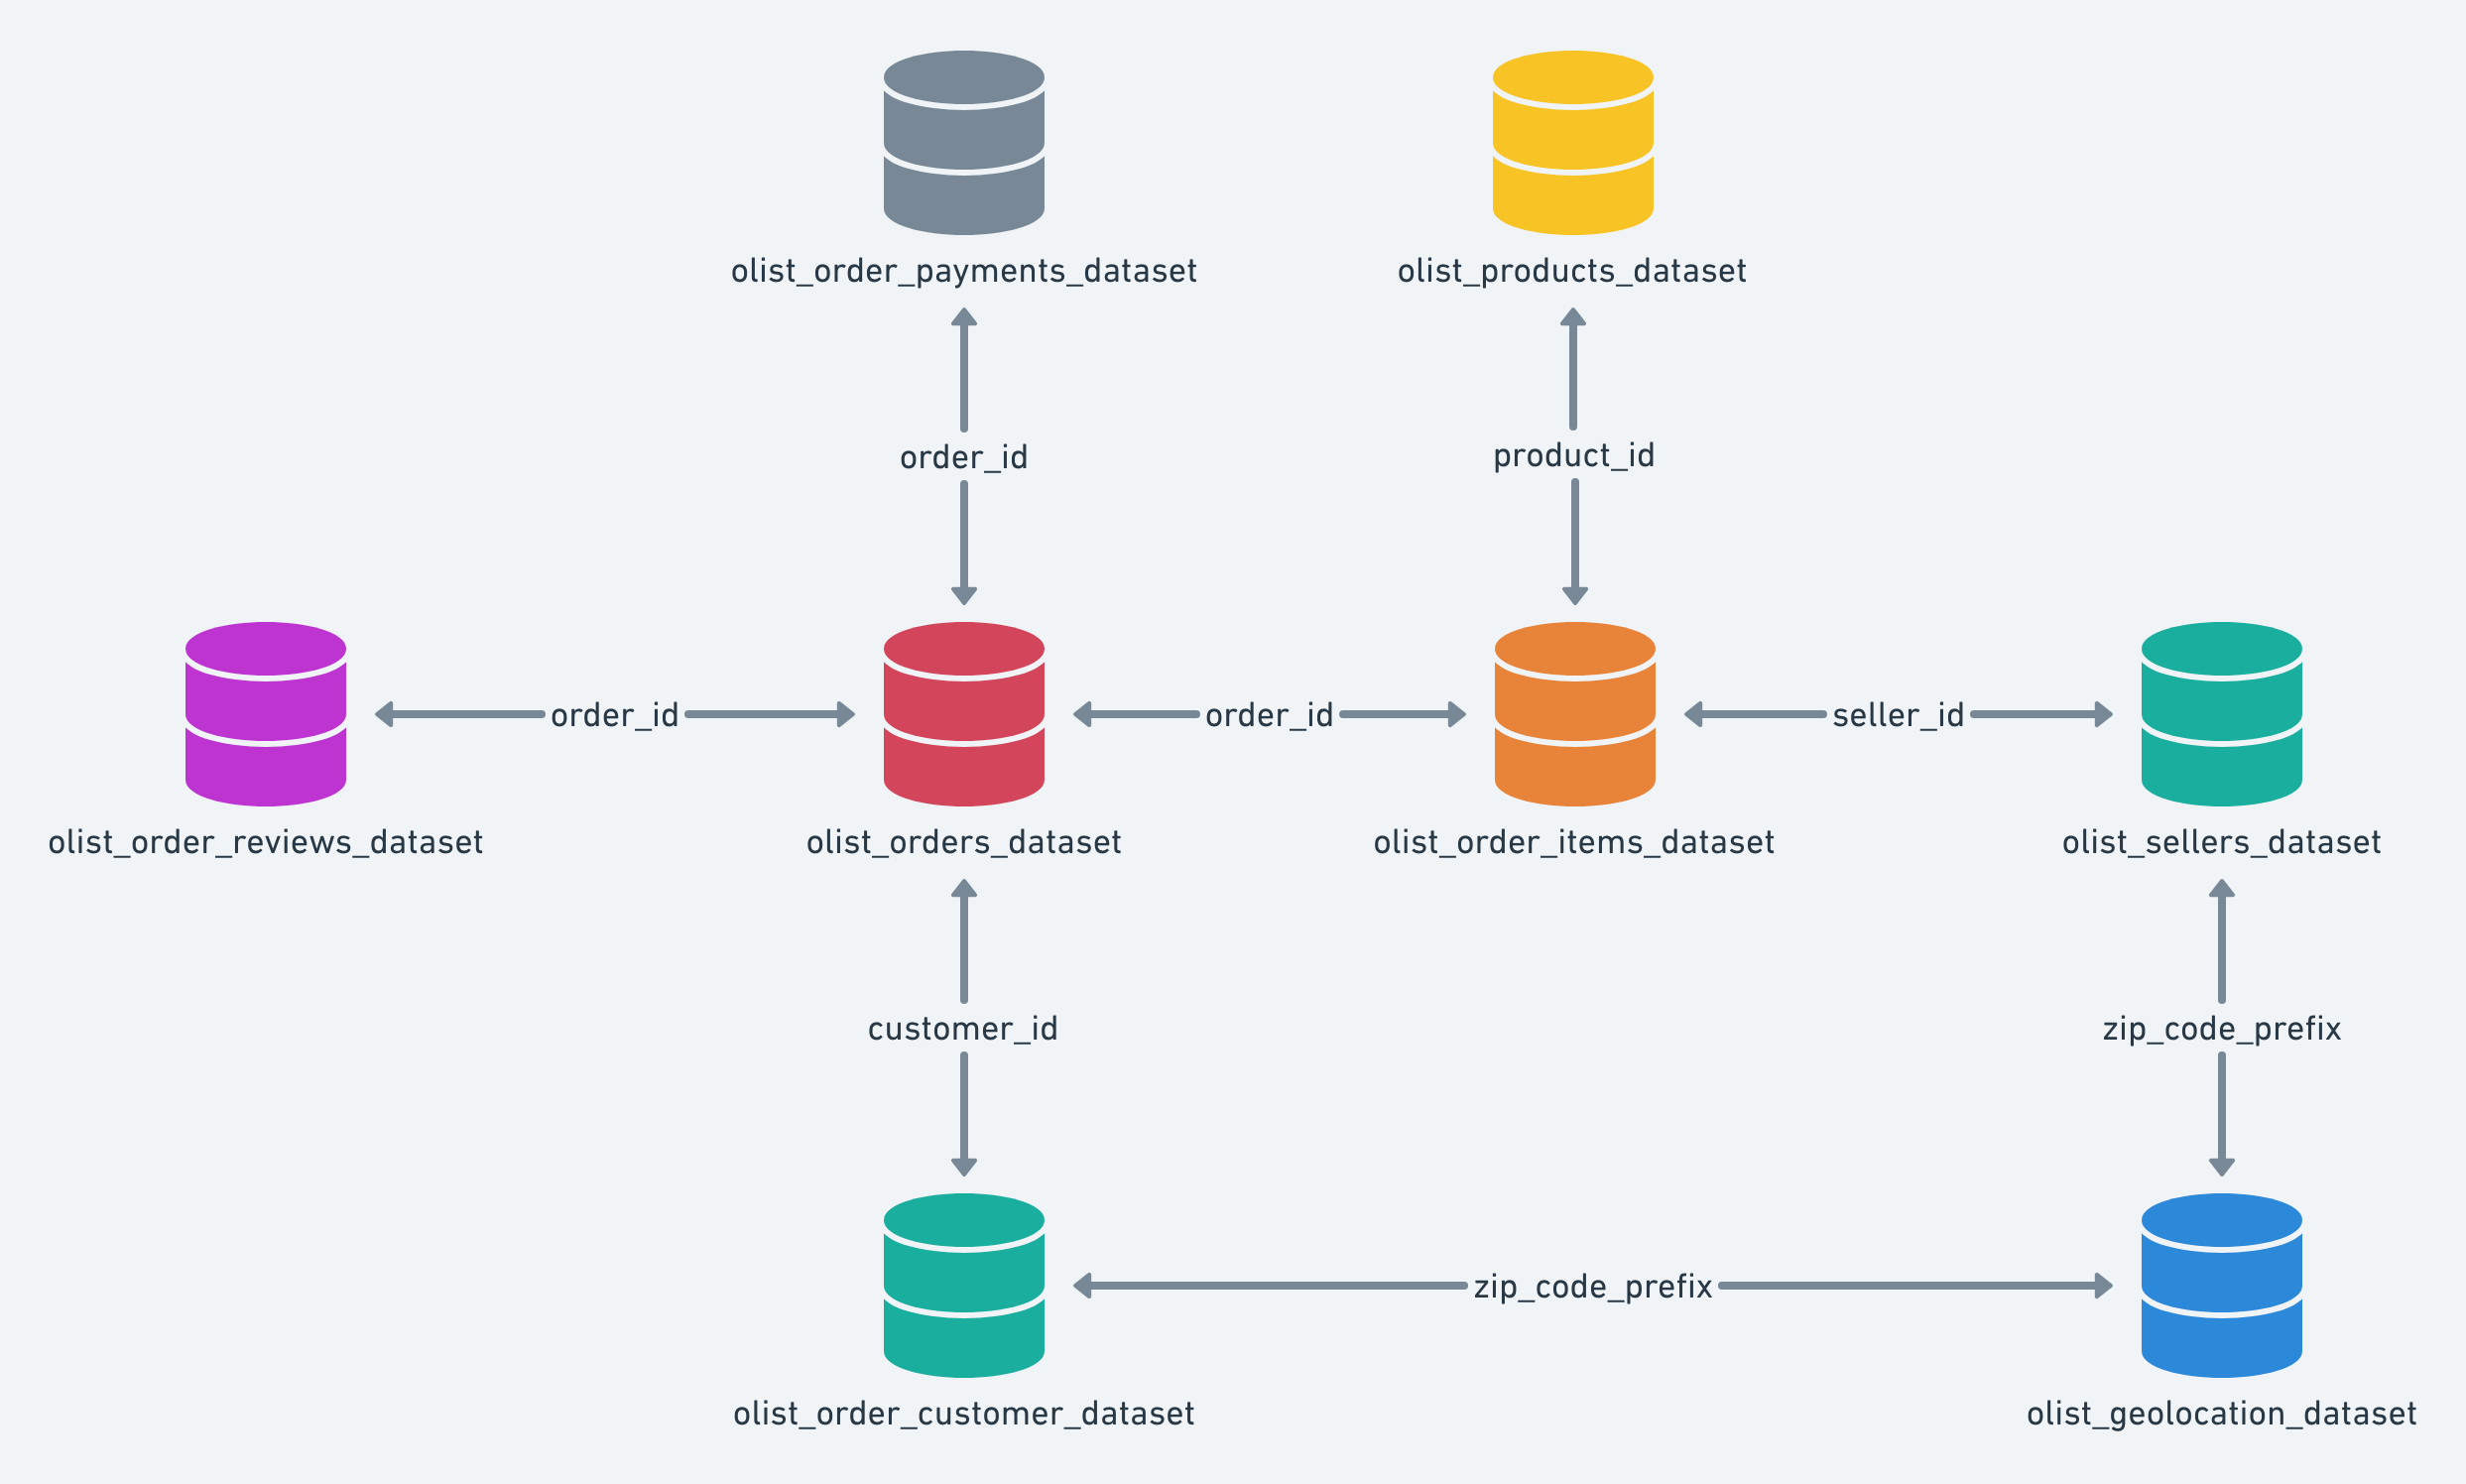



## Import Packages

In [4]:
import pandas as pd

from streamlit_lab.read_config import load_config
from streamlit_lab.extract_data import extract_data

In [ ]:
project_name = 'brazillian-ecommerce-analytics'
project_config = load_config(project_name)

all_dataset = extract_data(project_config['data_utils'])

Data already exists in /Users/palmmy/pyFreelance/brazillian-ecommerce-analytics/data/raw
Loaded: sellers with 3095 rows
Loaded: name_translation with 71 rows
Loaded: orders with 99441 rows
Loaded: order_items with 112650 rows
Loaded: customers with 99441 rows
Loaded: geolocation with 1000163 rows
Loaded: payments with 103886 rows
Loaded: reviews with 99224 rows
Loaded: products with 32951 rows


## Transform Data

#### 1. Convert Datetime Columns
Convert all Datetime field in any dataset from object to datetime

In [5]:
date_columns = {
    'orders': [
        'order_purchase_timestamp', 'order_approved_at'
        , 'order_delivered_carrier_date', 'order_delivered_customer_date'
        , 'order_estimated_delivery_date'
    ]
    , 'order_items': ['shipping_limit_date']
    , 'reviews': ['review_creation_date', 'review_answer_timestamp']
}

for table, columns in date_columns.items():
    for col in columns:
        if col in all_dataset[table].columns:
            all_dataset[table][col] = pd.to_datetime(all_dataset[table][col], errors='coerce')

#### 2. Create Derived Metrics for Orders

In [6]:
orders = all_dataset['orders'].copy()

# Delivery time metrics
orders['delivery_days'] = (
    orders['order_delivered_customer_date'] - orders['order_purchase_timestamp']
).dt.days

orders['estimated_delivery_days'] = (
    orders['order_estimated_delivery_date'] - orders['order_purchase_timestamp']
).dt.days

orders['delivery_delay_days'] = (
    orders['order_delivered_customer_date'] - orders['order_estimated_delivery_date']
).dt.days

orders['is_late'] = orders['delivery_delay_days'] > 0

# Time dimensions
orders['order_year'] = orders['order_purchase_timestamp'].dt.year
orders['order_month'] = orders['order_purchase_timestamp'].dt.month
orders['order_quarter'] = orders['order_purchase_timestamp'].dt.quarter
orders['order_day_of_week'] = orders['order_purchase_timestamp'].dt.dayofweek
orders['order_hour'] = orders['order_purchase_timestamp'].dt.hour
orders['order_date'] = orders['order_purchase_timestamp'].dt.date

In [7]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_days,estimated_delivery_days,delivery_delay_days,is_late,order_year,order_month,order_quarter,order_day_of_week,order_hour,order_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,8.0,15,-8.0,False,2017,10,4,0,10,2017-10-02
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,13.0,19,-6.0,False,2018,7,3,1,20,2018-07-24
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,9.0,26,-18.0,False,2018,8,3,2,8,2018-08-08
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,13.0,26,-13.0,False,2017,11,4,5,19,2017-11-18
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2.0,12,-10.0,False,2018,2,1,1,21,2018-02-13


#### 3. Aggregate order items to order level

In [8]:
order_items = all_dataset['order_items'].copy()

order_summary = order_items.groupby('order_id').agg({
    'price': 'sum'
    , 'freight_value': 'sum'
    , 'order_item_id': 'count'
    , 'product_id': 'nunique'
    , 'seller_id': 'nunique'
}).reset_index()

order_summary.columns = [
    'order_id', 'total_price', 'total_freight'
    , 'total_items', 'unique_products', 'unique_sellers'
]
order_summary['total_order_value'] = order_summary['total_price'] + order_summary['total_freight']

In [9]:
order_summary.head()

,order_id,total_price,total_freight,total_items,unique_products,unique_sellers,total_order_value
0,00010242fe8c5a6d1ba2dd792cb16214,58.90,13.29,1,1,1,72.19
1,00018f77f2f0320c557190d7a144bdd3,239.90,19.93,1,1,1,259.83
2,000229ec398224ef6ca0657da4fc703e,199.00,17.87,1,1,1,216.87
3,00024acbcdf0a6daa1e931b038114c75,12.99,12.79,1,1,1,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90,18.14,1,1,1,218.04


#### 4. Create fact table: orders with all metrics

In [10]:
fact_orders = orders.merge(order_summary, on='order_id', how='left')

# Add customer state
fact_orders = fact_orders.merge(
    all_dataset['customers'][['customer_id', 'customer_state', 'customer_city']]
    , on='customer_id', how='left'
)

# Add review score
reviews_agg = all_dataset['reviews'].groupby('order_id')['review_score'].mean().reset_index()
fact_orders = fact_orders.merge(reviews_agg, on='order_id', how='left')

In [11]:
fact_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_days,estimated_delivery_days,...,order_date,total_price,total_freight,total_items,unique_products,unique_sellers,total_order_value,customer_state,customer_city,review_score
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,8.0,15,...,2017-10-02,29.99,8.72,1.0,1.0,1.0,38.71,SP,sao paulo,4.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,13.0,19,...,2018-07-24,118.70,22.76,1.0,1.0,1.0,141.46,BA,barreiras,4.0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,9.0,26,...,2018-08-08,159.90,19.22,1.0,1.0,1.0,179.12,GO,vianopolis,5.0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,13.0,26,...,2017-11-18,45.00,27.20,1.0,1.0,1.0,72.20,RN,sao goncalo do amarante,5.0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2.0,12,...,2018-02-13,19.90,8.72,1.0,1.0,1.0,28.62,SP,santo andre,5.0


#### 5. Create product performance table

In [14]:
product_perf = order_items.merge(
    all_dataset['products'][['product_id', 'product_category_name']]
    , on='product_id', how='left'
)

product_perf = product_perf.merge(
    orders[['order_id', 'order_purchase_timestamp', 'order_status']]
    , on='order_id', how='left'
)

product_summary = product_perf.groupby(['product_id', 'product_category_name']).agg({
    'order_id': 'count'
    , 'price': 'sum'
    , 'order_status': lambda x: (x == 'delivered').sum()
}).reset_index()

product_summary.columns = [
    'product_id', 'category', 'total_orders'
    , 'total_revenue', 'delivered_orders'
]

In [15]:
product_summary.head()

,product_id,category,total_orders,total_revenue,delivered_orders
0,00066f42aeeb9f3007548bb9d3f33c38,perfumaria,1,101.65,1
1,00088930e925c41fd95ebfe695fd2655,automotivo,1,129.90,1
2,0009406fd7479715e4bef61dd91f2462,cama_mesa_banho,1,229.00,1
3,000b8f95fcb9e0096488278317764d19,utilidades_domesticas,2,117.80,2
4,000d9be29b5207b54e86aa1b1ac54872,relogios_presentes,1,199.00,1


#### 6. Create seller performance table

In [16]:
seller_items = order_items.merge(
    orders[['order_id', 'order_status']]
    , on='order_id'
)
seller_items = seller_items.merge(
    all_dataset['reviews'][['order_id', 'review_score']]
    , on='order_id', how='left'
)

seller_summary = seller_items.groupby('seller_id').agg({
    'order_id': 'nunique'
    , 'price': 'sum'
    , 'review_score': 'mean'
    , 'order_status': lambda x: (x == 'canceled').sum()
}).reset_index()

seller_summary.columns = [
    'seller_id', 'total_orders', 'total_revenue'
    , 'avg_rating', 'canceled_orders'
]

seller_summary = seller_summary.merge(
    all_dataset['sellers'][['seller_id', 'seller_state', 'seller_city']]
    , on='seller_id', how='left'
)

In [17]:
seller_summary.head()

,seller_id,total_orders,total_revenue,avg_rating,canceled_orders,seller_state,seller_city
0,0015a82c2db000af6aaaf3ae2ecb0532,3,2685.00,3.666667,0,SP,santo andre
1,001cca7ae9ae17fb1caed9dfb1094831,200,25080.03,3.902542,0,ES,cariacica
2,001e6ad469a905060d959994f1b41e4f,1,250.00,1.000000,1,RJ,sao goncalo
3,002100f778ceb8431b7a1020ff7ab48f,51,1254.40,3.982143,0,SP,franca
4,003554e2dce176b5555353e4f3555ac8,1,120.00,5.000000,0,GO,goiania


#### 7. Create daily metrics table

In [18]:
daily_metrics = fact_orders[fact_orders['order_status'] != 'canceled'].groupby('order_date').agg({
    'order_id': 'count'
    , 'total_order_value': 'sum'
    , 'total_items': 'sum'
    , 'customer_id': 'nunique'
    , 'review_score': 'mean'
    , 'is_late': 'mean'
}).reset_index()

daily_metrics.columns = [
    'date', 'orders', 'revenue', 'items_sold'
    , 'unique_customers', 'avg_rating', 'late_delivery_rate'
]
daily_metrics['date'] = pd.to_datetime(daily_metrics['date'])

# Calculate 7-day rolling averages
daily_metrics['revenue_7d_avg'] = daily_metrics['revenue'].rolling(7, min_periods=1).mean()
daily_metrics['orders_7d_avg'] = daily_metrics['orders'].rolling(7, min_periods=1).mean()

In [19]:
daily_metrics.head()

,date,orders,revenue,items_sold,unique_customers,avg_rating,late_delivery_rate,revenue_7d_avg,orders_7d_avg
0,2016-09-04,1,136.23,2.0,1,1.000000,0.000000,136.2300,1.00
1,2016-09-15,1,143.46,3.0,1,1.000000,1.000000,139.8450,1.00
2,2016-10-03,7,559.53,7.0,7,3.285714,0.000000,279.7400,3.00
3,2016-10-04,58,10900.95,67.0,58,3.775862,0.034483,2935.0425,16.75
4,2016-10-05,45,9504.95,55.0,45,3.325581,0.000000,4249.0240,22.40


#### 8. Create category performance table

In [20]:
category_perf = product_perf[product_perf['order_status'] != 'canceled'].groupby('product_category_name').agg({
    'order_id': 'count'
    , 'price': 'sum'
    , 'product_id': 'nunique'
}).reset_index()

category_perf.columns = ['category', 'total_orders', 'total_revenue', 'unique_products']
category_perf['avg_order_value'] = category_perf['total_revenue'] / category_perf['total_orders']
category_perf = category_perf.sort_values('total_revenue', ascending=False)

In [21]:
category_perf.head()

,category,total_orders,total_revenue,unique_products,avg_order_value
11,beleza_saude,9634,1255695.13,2430,130.339955
66,relogios_presentes,5970,1198185.21,1322,200.701040
13,cama_mesa_banho,11097,1035964.06,3022,93.355327
32,esporte_lazer,8590,979740.92,2850,114.055986
44,informatica_acessorios,7781,904322.02,1630,116.221825


#### 9. Create state-level metrics

In [22]:
state_metrics = fact_orders[fact_orders['order_status'] != 'canceled'].groupby('customer_state').agg({
    'order_id': 'count'
    , 'total_order_value': 'sum'
    , 'customer_id': 'nunique'
    , 'review_score': 'mean'
    , 'delivery_days': 'mean'
}).reset_index()

state_metrics.columns = [
    'state', 'total_orders', 'total_revenue'
    , 'unique_customers', 'avg_rating', 'avg_delivery_days'
]

In [23]:
state_metrics.head()

,state,total_orders,total_revenue,unique_customers,avg_rating,avg_delivery_days
0,AC,81,19669.70,81,4.049383,20.637500
1,AL,412,96229.40,412,3.765281,24.040302
2,AM,148,27835.73,148,4.205479,25.986207
3,AP,68,16262.80,68,4.194030,26.731343
4,BA,3364,606908.66,3364,3.868833,18.866400
